# **Named Entity Recognition with the Kaggle NER Dataset**

This notebook demonstrates the implementation of a Token Classification model using a Transformer network for the task of Named Entity Recognition (NER) with the [Kaggle NER Dataset](https://www.kaggle.com/datasets/namanj27/ner-dataset). For this task, the [BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding)](https://huggingface.co/docs/transformers/model_doc/bert) model from [Hugging Face 🤗](https://huggingface.co/) was fine-tuned to enhance its performance. Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced pre-trained NLP models like BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The BERT Large model from Hugging Face is used, a bidirectional transformer pre-trained with a combination of masked language modeling and next sentence prediction objectives on a large corpus comprising the Toronto Book Corpus and Wikipedia. This model has achieved state-of-the-art results in multiple natural language processing tasks, evaluated on datasets like GLUE, MultiNLI, and SQuAD. The model is loaded using the generic class [TFAutoModelForTokenClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelfortokenclassification), which allows for creating an instance of a pre-trained TensorFlow-based model specifically designed for token classification tasks, as it includes an appropriate classification layer on top. This differs from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has implemented a tokenizer for each of its models that returns everything needed for the respective model inputs. In this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows for instantiating the model’s tokenizer by its name alone. For this NER task, since the sentences are already separated into words, it is necessary to configure the tokenizer with the argument `is_split_into_words=True` to tokenize the words into subwords. The tokenizer returns `input_ids` (the tokenized sentences) and `attention_mask` (a mask to avoid attending to padding token indices).

 To tokenize the labels, they need to be realigned because the tokenizer adds some special tokens to the sentences, and subword tokenization creates a mismatch between the input and labels. A single word corresponding to a single label can now be split into multiple subwords. Therefore, the labels must be realigned by assigning all tokens to their corresponding word with the help of the tokenizer's `word_ids` method, assigning the label -100 to the special tokens `[CLS]`, `[SEP]`, and `[PAD]` so that the loss function ignores them, and labeling only the first token of a given word by assigning -100 to other subtokens of the same word.

- **TPU Usage:** Due to the enormous size of the BERT model, specifically `bert-large-cased`, which has over 300 million parameters, using a TPU in Google Colab is required to significantly accelerate training. Although only the parameters of the classification layer are fine-tuned, loading and processing pre-trained embeddings along with intensive backpropagation computations require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

- **Comparison with the [Bidirectional LSTM Network Model](https://github.com/JersonGB22/TokenClassification-TensorFlow/blob/main/models_lstm/NER_LSTM_Kaggle.ipynb):** In this notebook, the results obtained from the Transformer network using the BERT model are compared with the results obtained from the LSTM network model.

## **Imports**

In [1]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import TFAutoModelForTokenClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML

## **Parameters**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
epochs = 10
batch_size = 64
buffer_size = 1024
max_length = 128
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

# 'cased' enables the tokenizer to distinguish between uppercase and lowercase letters, which is useful for the NER task
model_name = "bert-large-cased"
train_filename = "/content/drive/MyDrive/Datasets/train_ner_bert.tfrecord"
val_filename = "/content/drive/MyDrive/Datasets/val_ner_bert.tfrecord"
test_filename = "/content/drive/MyDrive/Datasets/test_ner_bert.tfrecord"

## **Preprocessing and Saving Data in TFRecord Format**

Since the Kaggle's NER dataset is large and the BERT Large model is also substantial, the data is preprocessed, tokenized, and saved in TFRecord format, which allows for truly massive data pipeline performance for training on Colab's TPU. This is now more accessible as it is no longer necessary to store the TFRecord files in Google Cloud Storage due to the new version of Colab's TPU, ``TPU v2``, which has [transitioned from TPU Node to TPU VM](https://github.com/googlecolab/colabtools/issues/4481).

### **Load and Preprocess the Dataset**

The dataset was downloaded from the provided link on the official Kaggle website and then uploaded to my personal Google Drive. It comprises 4 columns: ``# Sentence``, ``Word``, ``POS``, and ``Tag``. For the NER task, we will utilize all columns except ``POS``, as it is used for another token classification task, namely [Part-of-Speech (PoS) Tagging](https://github.com/JersonGB22/TokenClassification-TensorFlow/blob/main/models_lstm/PoS_LSTM_Kaggle.ipynb).

**NER Label Descriptions:**

- **O: Outside**. Indicates that the word does not belong to any named entity.
- **B-geo: Beginning of a geographic location**. Indicates that the word is the beginning of a geographic entity (e.g., a country, city, or place).
- **I-geo: Inside of a geographic location**. Indicates that the word is part of a geographic entity but is not the beginning.
- **B-tim: Beginning of a time expression**. Indicates that the word is the beginning of a temporal expression (e.g., a date or time).
- **I-tim: Inside of a time expression**. Indicates that the word is part of a temporal expression but is not the beginning.
- **B-org: Beginning of an organization**. Indicates that the word is the beginning of an organizational entity (e.g., a company or institution).
- **I-org: Inside of an organization.** Indicates that the word is part of an organizational entity but is not the beginning.
- **B-per: Beginning of a person**. Indicates that the word is the beginning of an entity referring to a person.
- **I-per: Inside of a person**. Indicates that the word is part of an entity referring to a person but is not the beginning.
- **B-gpe: Beginning of a geopolitical entity**. Indicates that the word is the beginning of a geopolitical entity (e.g., a country, state, or city).
- **I-gpe: Inside of a geopolitical entity**. Indicates that the word is part of a geopolitical entity but is not the beginning.
- **B-art: Beginning of an artifact**. Indicates that the word is the beginning of an entity referring to an artifact (e.g., a work of art, a book).
- **I-art: Inside of an artifact**. Indicates that the word is part of an entity referring to an artifact but is not the beginning.
- **B-eve: Beginning of an event**. Indicates that the word is the beginning of an entity referring to an event (e.g., a conference, a match).
- **I-eve: Inside of an event**. Indicates that the word is part of an entity referring to an event but is not the beginning.
- **B-nat: Beginning of a natural phenomenon**. Indicates that the word is the beginning of an entity referring to a natural phenomenon (e.g., a hurricane, an earthquake).
- **I-nat: Inside of a natural phenomenon**. Indicates that the word is part of an entity referring to a natural phenomenon but is not the beginning.

In [4]:
# Unzip the dataset
!unzip -q /content/drive/MyDrive/Datasets/ner_datasetreference.csv.zip

In [5]:
df = pd.read_csv("/content/ner_datasetreference.csv", encoding="latin1")

# Completing missing values in the 'Sentence #' column using previous values
df["Sentence #"].fillna(method="ffill", inplace=True)

# Remove sentences containing at least one null Word
sentences_nan = df[df.Word.isna()]["Sentence #"].unique()
df = df[~df["Sentence #"].isin(sentences_nan)]

# Variable to view the count of values for each 'Tag'
tag_counts = df.Tag.value_counts()

# Grouping words and tags by sentence
df = df.groupby("Sentence #")[["Word", "Tag"]].agg(lambda x: x.values.tolist())
df

,Word,Tag
Sentence #,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...
Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."


In [6]:
tag_counts

Tag
O        887788
B-geo     37643
B-tim     20331
B-org     20142
I-per     17251
B-per     16990
I-org     16783
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

It can be observed that the dataset is unbalanced regarding the "Tag" values, with the most affected ones ranging from ``B-art`` to ``I-nat``.

In [7]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47949 entries, Sentence: 1 to Sentence: 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    47949 non-null  object
 1   Tag     47949 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


**Splitting the dataframe into training (70%), validation (15%) y testing (15%) sets**

In [8]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=SEED)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=SEED)

del df, df_val_test #Remove to free memory

len(df_train), len(df_val), len(df_test)

(33564, 7192, 7193)

In [ ]:
# Save the test dataset for predictions
df_test.to_json("/content/drive/MyDrive/Datasets/test_dataset_ner.json", orient="records")

### **Sentence Encoder**

**Import the AutoTokenizer**

In [10]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

BertTokenizerFast(name_or_path='bert-large-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [11]:
# Example of sentence tokenization

id = 15
example = df_train.Word[id]
print("Example:\n", example, "\n")

encoding = tokenizer(
    example,
    padding="max_length",
    truncation=True,
    max_length=25,
    is_split_into_words=True,
    return_tensors="tf" #Returns the results in TensorFlow tensor format
)

print("Ids:\n", encoding["input_ids"].numpy()[0], "\n")
print("Tokens:\n", tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]), "\n")
print("Decoded Text without Special Tokens:\n", tokenizer.decode(encoding["input_ids"][0], skip_special_tokens=True), "\n\n")

print("IDs of the Individual Words:\n", encoding.word_ids(), "\n\n")

print("Attention Mask:\n", encoding["attention_mask"].numpy()[0])

Example:
 ['The', 'Constituent', 'Assembly', 'elected', 'the', 'country', "'s", 'first', 'president', 'in', 'July', '.'] 

Ids:
 [  101  1109 16752  2050  2875 23404  1204  2970  1809  1103  1583   112
   188  1148  2084  1107  1351   119   102     0     0     0     0     0
     0] 

Tokens:
 ['[CLS]', 'The', 'Con', '##st', '##it', '##uen', '##t', 'Assembly', 'elected', 'the', 'country', "'", 's', 'first', 'president', 'in', 'July', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 

Decoded Text without Special Tokens:
 The Constituent Assembly elected the country's first president in July. 


IDs of the Individual Words:
 [None, 0, 1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, None, None, None, None, None, None, None] 


Attention Mask:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


The number of tokenized question pairs in the training set that exceed the length of 128 tokens is only 1, so it is sufficient in this case for the `max_length` to be 128.

```
li = []
for _, row in df_train.iterrows():
  li.append(len(tokenizer(row["Word"], truncation=True, is_split_into_words=True)["input_ids"]))

print(len([x for x in li if x > 128]))
# Output: 1
```

In [12]:
# Function to tokenize sentences

def encoder_x(sentence, return_tensors=None, return_word_ids=True):
  encoding = tokenizer(
      sentence,
      padding="max_length",
      truncation=True,
      max_length=max_length,
      is_split_into_words=True,
      return_tensors=return_tensors
  )

  if return_word_ids:
    return encoding["input_ids"], encoding["attention_mask"], encoding.word_ids()
  else:
    return encoding["input_ids"], encoding["attention_mask"]

### **Label Encoder**

In [13]:
# Generate the label vocabulary
vocab_y = {t:i for i, t in enumerate(tag_counts.index)}
print(len(vocab_y))
vocab_y

17


{'O': 0,
 'B-geo': 1,
 'B-tim': 2,
 'B-org': 3,
 'I-per': 4,
 'B-per': 5,
 'I-org': 6,
 'B-gpe': 7,
 'I-geo': 8,
 'I-tim': 9,
 'B-art': 10,
 'B-eve': 11,
 'I-art': 12,
 'I-eve': 13,
 'B-nat': 14,
 'I-gpe': 15,
 'I-nat': 16}

In [14]:
# Class for aligned label tokenization
class LabelEncoder():
  def __init__(self, vocab):
    self.vocab = vocab
    self.vocab_inv = {v:k for k, v in vocab.items()}

  def text_to_sequence(self, label):
    labels_ids = [self.vocab[w] for w in label]
    return labels_ids

  def align_tokenization(self, label, word_ids):
    label_ids = self.text_to_sequence(label)
    previous_id = None
    label_ids_align = []

    for id in word_ids:
      if id is None:
        label_ids_align.append(-100)
      elif id != previous_id:
        label_ids_align.append(label_ids[id])
      else:
        label_ids_align.append(-100)
      previous_id = id

    return label_ids_align

  def sequence_to_text(self, label_ids, join=True):
    label = [self.vocab_inv[id] for id in label_ids if id != -100]
    if join:
      label = " ".join(label)
    return label

In [15]:
encoder_y = LabelEncoder(vocab_y)

In [16]:
# Example of label tokenization

id = 15
example = df_train.Tag[id]

print("Example:\n", example, "\n")
print("IDs:\n", encoder_y.text_to_sequence(example), "\n\n")
_, _, word_ids = encoder_x(df_train.Word[id])
print("Aligned IDs:\n", encoder_y.align_tokenization(example, word_ids), "\n")
print("IDs of the Individual Words in the Sentence:\n", word_ids, "\n")

print("Decoded Label:\n", encoder_y.sequence_to_text(encoder_y.align_tokenization(example, word_ids)))

Example:
 ['O', 'B-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O'] 

IDs:
 [0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0] 


Aligned IDs:
 [-100, 0, 3, -100, -100, -100, -100, 6, 0, 0, 0, 0, -100, 0, 0, 0, 2, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100] 

IDs of the Individual Words in the Sentence:
 [None, 0, 1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, None, None, No

### **Saving Data in TFRecord Format**

In [ ]:
def save_tfrecord(filename, df):
  with tf.io.TFRecordWriter(filename) as writer:
    for _, row in df.iterrows():
      input_ids, attention_mask, word_ids = encoder_x(row["Word"])
      label_ids = encoder_y.align_tokenization(row["Tag"], word_ids)

      features = {
          "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
          "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
          "labels": tf.train.Feature(int64_list=tf.train.Int64List(value=label_ids))
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
save_tfrecord(train_filename, df_train)
save_tfrecord(val_filename, df_val)
save_tfrecord(test_filename, df_test)

## **Using the TPU for Training**

From here onwards until 'Predictions with the Trained Model', we use the TPU, with each epoch taking approximately 1.5 minutes to complete.

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


### **Loading the Preprocessed Datasets**

In [ ]:
train_size, val_size, test_size = 33564, 7192, 7193

In [ ]:
def decode_tfrecord(sample):
  features = {
      "input_ids": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "attention_mask": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "labels": tf.io.FixedLenFeature((max_length, ), tf.int64),
  }

  parsed_features = tf.io.parse_example(sample, features)
  input_ids = parsed_features["input_ids"]
  attention_mask = parsed_features["attention_mask"]
  labels = parsed_features["labels"]

  return (input_ids, attention_mask), labels


def load_dataset(filename, size, shuffle=False):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))

  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)

  return dataset

In [ ]:
train_dataset = load_dataset(train_filename, train_size, shuffle=True)
val_dataset = load_dataset(val_filename, val_size)
test_dataset = load_dataset(test_filename, test_size)

In [ ]:
# Viewing a training batch
for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[  101  1247  1110 ...     0     0     0]
 [  101  1828   119 ...     0     0     0]
 [  101 13236  1145 ...     0     0     0]
 ...
 [  101  4306  1107 ...     0     0     0]
 [  101  1760  1429 ...     0     0     0]
 [  101   138   158 ...     0     0     0]], shape=(64, 128), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(64, 128), dtype=int64) 

tf.Tensor(
[[-100    0    0 ... -100 -100 -100]
 [-100    5 -100 ... -100 -100 -100]
 [-100    0    0 ... -100 -100 -100]
 ...
 [-100    2    0 ... -100 -100 -100]
 [-100    0    3 ... -100 -100 -100]
 [-100    0    7 ... -100 -100 -100]], shape=(64, 128), dtype=int64)


### **Creation and Training of the Model**


Due to the incompatibility of using the `SparseCategoricalCrossentropy` loss function with the `ignore_class` argument on Google Colab's TPU, it is necessary to create a custom loss function that masks the value of -100 to prevent errors. Additionally, a masked accuracy function is implemented. The code for the masked loss function was taken from the [official Hugging Face GitHub repository](https://github.com/huggingface/transformers/blob/main/src/transformers/modeling_tf_utils.py#L255), where this loss is tailored specifically for token classification models.

In [ ]:
def masked_accuracy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
  mask = tf.cast(tf.not_equal(y_true, -100.0), tf.float32)

  matches_true_pred = tf.cast(tf.equal(y_true, y_pred), tf.float32)
  matches_true_pred *= mask
  masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

  return masked_acc


def masked_loss(labels, logits):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE
  )

  masked_loss = loss_fn(tf.nn.relu(labels), logits)
  mask = tf.cast(labels >= 0, dtype=masked_loss.dtype)
  masked_loss *= mask
  reduced_masked_loss = tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

  return reduced_masked_loss

In [ ]:
# Callback to stop training early if validation accuracy does not improve for 2 epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForTokenClassification.from_pretrained(model_name, num_labels=17)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int32)
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int32)
  x = model_base(input_ids=input_ids, attention_mask=attention_mask).logits

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
      loss=masked_loss,
      metrics=[masked_accuracy],
      steps_per_execution=100
  )

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_for_token_classifi  TFTokenClassifierOutput(lo   3325470   ['input_1[0][0]',             
 cation (TFBertForTokenClas  ss=None, logits=(None, 128   89         'input_2[0][0]']             
 sification)                 , 17),                                                               
                              hidden_states=None, atten                                       

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/10
524/524 [==============================] - 374s 713ms/step - loss: 0.1803 - masked_accuracy: 0.9529 - val_loss: 0.1019 - val_masked_accuracy: 0.9700
Epoch 2/10
524/524 [==============================] - 85s 162ms/step - loss: 0.0899 - masked_accuracy: 0.9723 - val_loss: 0.0904 - val_masked_accuracy: 0.9726
Epoch 3/10
524/524 [==============================] - 84s 160ms/step - loss: 0.0705 - masked_accuracy: 0.9773 - val_loss: 0.0904 - val_masked_accuracy: 0.9725
Epoch 4/10
524/524 [==============================] - 85s 162ms/step - loss: 0.0559 - masked_accuracy: 0.9816 - val_loss: 0.0974 - val_masked_accuracy: 0.9729
Epoch 5/10
524/524 [==============================] - 84s 160ms/step - loss: 0.0447 - masked_accuracy: 0.9852 - val_loss: 0.1077 - val_masked_accuracy: 0.9721
Epoch 6/10
524/524 [==============================] - 98s 187ms/step - loss: 0.0342 - masked_accuracy: 0.9883 - val_loss: 0.1183 - val_masked_accuracy: 0.9728


### **Save model**

In [18]:
trained_model_path = "/content/drive/MyDrive/models/NER_BERT_Kaggle"

In [ ]:
model.layers[2].save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.03626985102891922, 0.9877713918685913]
[0.09742273390293121, 0.9729200005531311]
[0.10109440237283707, 0.9718411564826965]


**Consolidating the accuracy of the testing set**

In [ ]:
labels_test = test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_test = np.array(list(labels_test))

labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)
mask = (labels_test != -100).astype(np.float32)
matches_true_pred = (labels_test == labels_test_pred).astype(np.float32)
matches_true_pred *= mask

masked_accuracy = np.sum(matches_true_pred) / np.sum(mask)
masked_accuracy

0.9716585

Although the LSTM model showed quite good performance, the Transformer model achieves superior results, reaching an accuracy of **98.8%** on the training set in just 4 epochs. Additionally, it achieves **97.3%** on the validation set and **97.2%** on the test set. These results highlight the slight superiority of the Transformer model over the bidirectional LSTM, which achieved an accuracy of **96.7%** on the test set. It is important to note that with continued training, the accuracy of the training set could reach 100%, while that of the validation and test sets would decrease, emphasizing the importance of using a callback to stop training when the validation set accuracy does not improve for two consecutive epochs, thus preventing overfitting. Furthermore, the Transformer model could achieve better results if the Kaggle NER dataset were more balanced in terms of the minority tags observed earlier.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics(metric="masked_accuracy")
plot_metrics()

**Images for GitHub**

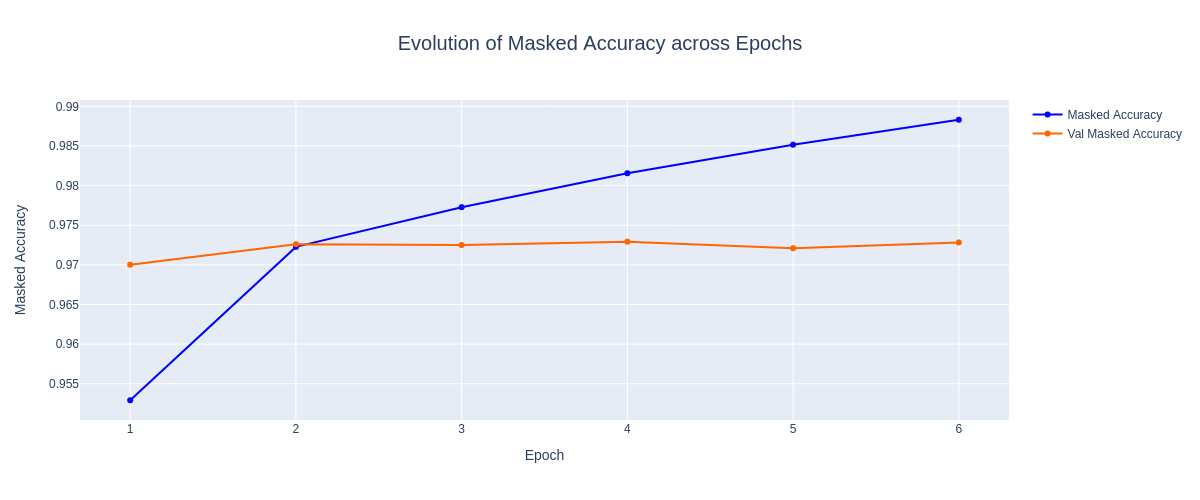

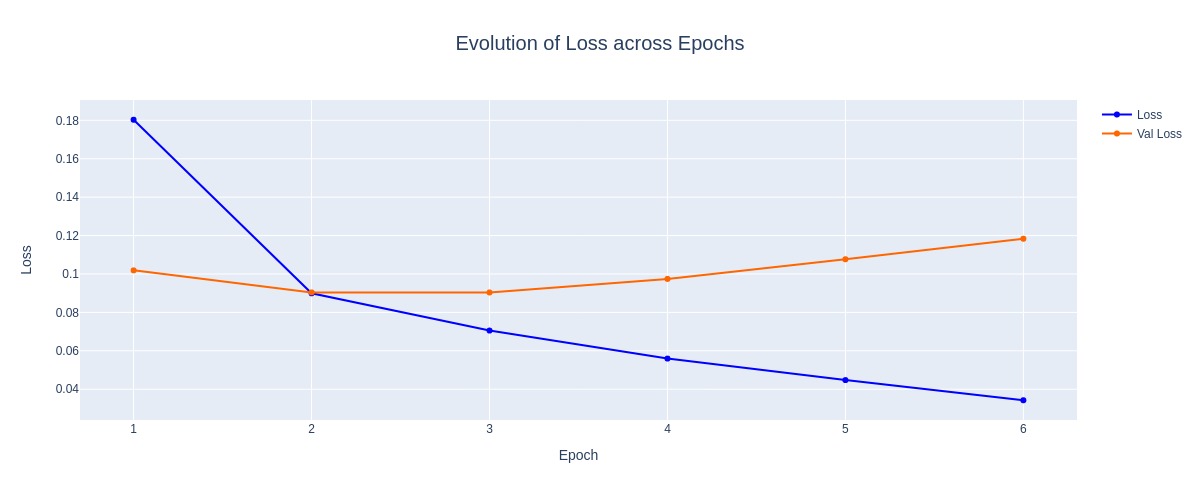

In [ ]:
plot_metrics(renderer="png", metric="masked_accuracy")
plot_metrics(renderer="png")

## **Predictions with the Trained Model**

**Load the trained model and the testing dataframe**

In [19]:
model = TFAutoModelForTokenClassification.from_pretrained(trained_model_path, num_labels=17)
df_test = pd.read_json("/content/drive/MyDrive/Datasets/test_dataset_ner.json")

All model checkpoint layers were used when initializing TFBertForTokenClassification.

All the layers of TFBertForTokenClassification were initialized from the model checkpoint at /content/drive/MyDrive/models/NER_BERT_Kaggle.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


**Function to predict named entities**

In [20]:
def predict_label(sentences, labels=None, random=True, indice=0):
  indice = np.random.choice(len(sentences)) if random else indice
  sentence = sentences[indice]

  # For other sentences that are not in the test set
  if type(sentence) == str:
    sentence = sentence.split(" ")

  input_ids, attention_mask, word_ids = encoder_x(sentence, return_tensors="tf")

  # Mask to reverse the alignment of predicted label tokenization
  mask = [i for i, id in enumerate(word_ids) if (id != None) and (id not in word_ids[:i])]

  label_ids_pred = model(input_ids, attention_mask).logits.numpy()
  label_ids_pred = np.argmax(label_ids_pred, axis=-1)[0]
  label_ids_pred = label_ids_pred[mask]
  label_pred = encoder_y.sequence_to_text(label_ids_pred, join=False)

  display(HTML(f"<b>Sentence:</b> {' '.join(sentence)}<br><br>"))
  html_content = """
  <table style="border-collapse: separate; border-spacing: 15px; text-align: center;">
    <tr>
      <th>Word</th>
      <th>Predicted Tag</th>
  """

  if labels is not None:
    label_colors = {"incorrect":"red", "correct":"green"}
    label = labels[indice]
    html_content += "<th>True Tag</th>"
  html_content += "</tr>"

  for i in range(len(label_pred)):
    cond = label[i] if labels is not None  else label_pred[i]
    if cond != "O":

      html_content += f"""
        <tr>
          <td>{sentence[i]}</td>
          <td>{label_pred[i]}</td>
        """

      if labels is not None:
        result = "correct" if label[i] == label_pred[i]  else "incorrect"

        html_content += f"""
          <td>{label[i]}</td>
          <td><b><span style="color:{label_colors[result]}">{result}</span></b></td>
        """
      html_content += "</tr>"

  html_content += "</table>"
  display(HTML(html_content))

### **Test Dataset**

In [ ]:
sentences, labels = df_test.Word.values, df_test.Tag.values

In [ ]:
predict_label(sentences, labels, random=False)

In [ ]:
predict_label(sentences, labels)

In [ ]:
predict_label(sentences, labels, random=False, indice=109)

In [ ]:
predict_label(sentences, labels)

Word,Predicted Tag,True Tag


In [ ]:
predict_label(sentences, labels, random=False, indice=-2)

In [ ]:
# The model predicted all tags correctly
predict_label(sentences, labels, random=False, indice=978)

In [ ]:
predict_label(sentences, labels, random=False, indice=2093)

### **Other Sentences**

In [21]:
# The model also detected 'fall' as a temporal expression

sentence = ["George Smith , the White House director of trade and manufacturing policy of U.S , said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall ."]
predict_label(sentence)

Word,Predicted Tag
George,B-per
Smith,I-per
White,B-org
House,I-org
U.S,B-geo
Sunday,B-tim
morning,I-tim
White,B-org
House,I-org
fall,B-tim


In [22]:
sentence = ["In Tokyo , Japan , the United Nations announced on Monday that they will hold a global climate summit in December . The event , which will include representatives from over 150 countries , aims to address the urgent issues of climate change and global warming . UN Secretary-General Anthony Gutierres emphasized the need for immediate action to protect the planet ."]
predict_label(sentence)

Word,Predicted Tag
Tokyo,B-geo
Japan,B-geo
United,B-org
Nations,I-org
Monday,B-tim
December,B-tim
UN,B-org
Secretary-General,I-org
Anthony,B-per
Gutierres,I-per


In [25]:
sentence = ["Barack Obama , the former President of the United States , delivered a speech at the United Nations General Assembly in New York City on Tuesday . He discussed global cooperation in addressing challenges such as climate change , terrorism , and economic inequality . Obama urged world leaders to work together for a better future ."]
predict_label(sentence)

Word,Predicted Tag
Barack,B-per
Obama,I-per
President,B-per
United,B-geo
States,I-geo
United,B-org
Nations,I-org
General,I-org
Assembly,I-org
New,B-geo


**Conclusion:** It can be observed that the model performs quite well in accurately detecting named entities in sentences from the test set, as well as in others not belonging to the Kaggle NER Dataset, even if they are long or complex. It is also evident that the model's predictions improved slightly compared to the bidirectional LSTM model. However, due to the imbalance of the dataset regarding minority tags, the model shows deficiencies in tags with lower frequency in sentences, such as ``B-art`` and ``I-art``. Therefore, while the model is excellent, enhancing its performance will require expanding the training dataset with sentences containing the minority tags to balance them with the other tags.